In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-bright')

In [2]:
def generate_microstates(n):
    states = [list(format(i, f'0{n}b')) for i in range(2**n)]
    return {tuple(map(int, state)) for state in states}
    #return states

In [3]:
# constants
S_REF = 1.2
T_REF = 298
SIGMA = 0.001
R = 8.314
LO_THRESH = 2   # lower threshold for number of ordered residues to consider as start of folding path.


def get_s_temp(temp, s_ref=S_REF):
    # get the s value at the given temperature
    s = math.pow(s_ref, (T_REF/temp))
    return s

def calc_penalty(state, s_temp):
    # calc penalty for the given state as sigma*s^nhelix
    state = [1 if int(i) == 1 else 0 for i in state]
    nhelix = np.sum(state)
    return SIGMA * math.pow(s_temp, nhelix)

def compute_free_energy(state, temp):
    # calc free energy of the state
    s_temp = get_s_temp(temp)
    penalty = calc_penalty(state, s_temp)
    energy = -R*temp*math.log(penalty)
    return energy

In [4]:
def get_sw(dE, T=298):
    # calculates the statistical weight
    R = 8.314
    w = np.exp(-dE/(R*T))
    return w

In [5]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.6 MB/s eta 0:00:00


In [6]:
from Levenshtein import distance

# this code block can be ignored for now.
def get_key(state):
    return ''.join([str(i) for i in state])

def generate_ssa_seqs(nres):
    seqs = []

    for start in range(nres):
        for end in range(nres):
            seq = [0]*nres
            if start <= end:
                seq[start:end+1] = [1]*(end-start+1)
            seq = ''.join([str(i) for i in seq])
            seqs.append(seq)
    return list(set(seqs))

def get_distance(seq1, seq2):
    dist = distance(seq1, seq2)
    return dist

def neighbours(seq, total_seqs):
    nlist = []
    for i in total_seqs:
        if get_distance(seq, i) == 1:
            temp = list(i)
            temp = [int(i) for i in temp]
            nlist.append(temp)
    return nlist

def generate_neighbour_list(total_seqs):
    neighbour_dict = {}
    for i in total_seqs:
        neighbour_dict[i] = neighbours(i, total_seqs)
    return neighbour_dict

In [7]:
def get_folding_route(path):
    # finds the folding path using the generated path
    reverse_path = path[::-1]
    folding_path = []
    for i in reverse_path:
        helix = [int(j) for j in range(len(i)) if i[j] == '1']
        if len(helix) < LO_THRESH:
            break
        else:
            folding_path.append(i)

    return folding_path[::-1]

In [8]:
def check_if_allowed(curr_state, residue):
    # # check if residue is helix or coil
    # # if helix then check if it is on the edge of helix
    # # if yes then return true
    # # else return false

    # # if coil then check if helix already exists
    # # if yes then return false
    # # if no then return true

    helix = [int(i) for i in range(len(curr_state)) if curr_state[i] == '1']
    # print(helix)
    if residue in helix:
        if residue == helix[0] or residue == helix[-1]:
            return True
        else:
            return False
    else:
        if len(helix) == 0:
            return True
        else:
            if residue+1 == helix[0] or residue-1 == helix[-1]:
                return True
            else:
                return False



In [9]:
def monte_carlo_folding(n, steps=10000, temp = 298):
    microstates = generate_ssa_seqs(n)
    state_energy = {state: compute_free_energy(state, temp) for state in microstates}
    # display(state_energy)
    start_state = ''.join(['0']*n)
    # print('start state', start_state)
    # print(microstates)
    macrostates = []
    path = []
    current_state = start_state
    next_state = current_state
    for i in range(steps):
        path.append(current_state)
        temp_lst = [int(i) for i in current_state]
        nhelix = sum(temp_lst)
        macrostates.append(nhelix)
        if current_state != '1'*n:
            # pick random neighbour
            # print(current_state)
            residue = random.randint(0, n-1)
            # print(residue)
            # check if after modifying residue in state, the state is in accessibles

                #chosen_state = min(neighbors, key=lambda s: state_energy[s])
            if check_if_allowed(current_state, residue):
                next_state = current_state[:residue] + str(1-int(current_state[residue])) + current_state[residue+1:]
                # print('next state', next_state)
            else:
                next_state = current_state
                # path.append(current_state)
                continue

            dE = state_energy[next_state] - state_energy[current_state] # compute energy difference
            temp_lst = [int(i) for i in current_state]
            nhelix = sum(temp_lst)
            # print('delta', dE)
            w = get_sw(dE, temp)

            # if w > 1: move to next state
            # if w <= 1: get random number r between 0 and 1 and if w >= r, move to next state
            # else stay in current state

            if w > 1:
                current_state = next_state
            else:
                r = random.random()
                if w >= r:
                    current_state = next_state
                else:
                    pass
            # path.append(current_state)

        else:
            # print(len(path), i)
            break
        # print(path)
        # if i % 10000 == 0:
            # print(f'{i} steps completed')

    return path, macrostates

In [22]:
all_path=[]
all_ms = []
for i in range(10000):
    path, macrostates = monte_carlo_folding(15)
    # print(f"Estimated number of microscopic folding routes: {len(path)}")
    all_path.append(path)
    all_ms.append(macrostates)
    if i+1 % 1000 == 0:
        print(f'{i+1} steps completed')


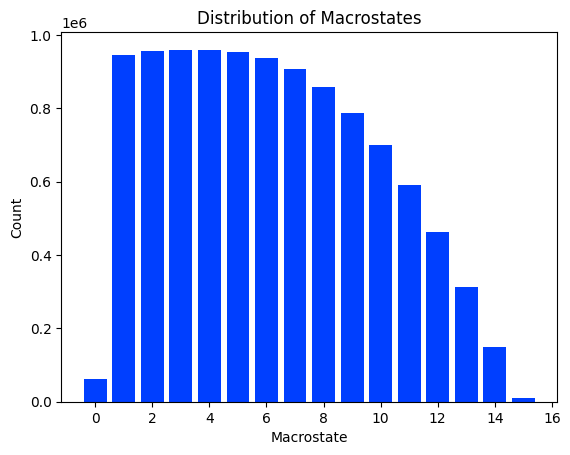

In [51]:
from collections import Counter
macrostate_counts = {}

for macrostates in all_ms:
    for macrostate in macrostates:
        macrostate_counts[macrostate] = (macrostate_counts.get(macrostate, 0) + 1)

plt.bar(macrostate_counts.keys(), macrostate_counts.values())
plt.xlabel('Macrostate')
plt.ylabel('Count')
plt.title('Distribution of Macrostates')
plt.show()

In [30]:
folding_paths = []
for path in all_path:
    folding_paths.append(get_folding_route(path))

from collections import Counter
microstate_counts = {}

for path in folding_paths:
    for microstate in path:
        microstate_counts[microstate] = (microstate_counts.get(microstate, 0) + 1)

sorted_microstates = sorted(microstate_counts.items(), key=lambda x: x[1], reverse=True)

[('000111111111111', 91703), ('111111111111000', 89762), ('001111111111111', 88035), ('111111111111100', 87107), ('000011111111111', 87017), ('111111111110000', 85492), ('011111111111100', 81554), ('011111111111000', 80412), ('001111111111110', 80406), ('111111111100000', 78816), ('000111111111110', 78716), ('000001111111111', 77607), ('011111111111110', 75530), ('001111111111100', 74266), ('000011111111110', 73054), ('011111111110000', 72971), ('001111111111000', 70460), ('000111111111100', 69127), ('000000111111111', 67355), ('000001111111110', 66230), ('111111111111110', 66165), ('111111111000000', 65893), ('011111111111111', 65816), ('011111111100000', 64196), ('000011111111100', 63266), ('001111111110000', 62294), ('000111111111000', 60793), ('000000011111111', 56584), ('000000111111110', 56220), ('011111111000000', 55861), ('111111110000000', 55851), ('000001111111100', 55029), ('001111111100000', 54656), ('000111111110000', 54046), ('000011111111000', 53158), ('000111111100000',

('000111111111111', '111111111111000', '001111111111111', '111111111111100', '000011111111111', '111111111110000', '011111111111100', '011111111111000', '001111111111110', '111111111100000', '000111111111110', '000001111111111', '011111111111110', '001111111111100', '000011111111110', '011111111110000', '001111111111000', '000111111111100', '000000111111111', '000001111111110', '111111111111110', '111111111000000', '011111111111111', '011111111100000', '000011111111100', '001111111110000', '000111111111000', '000000011111111', '000000111111110', '011111111000000', '111111110000000', '000001111111100', '001111111100000', '000111111110000', '000011111111000', '000111111100000', '000000011111110', '000000111111100', '000001111111000', '011111110000000', '000011111110000', '001111111000000', '000000001111111', '111111100000000', '000000111111000', '000011111100000', '000001111110000', '000111111000000', '001111110000000', '000000011111100', '000000001111110', '011111100000000', '1111110000

<ipython-input-45-8bb128c4b26b>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(group['microstate'], rotation=45, ha='right')
<ipython-input-45-8bb128c4b26b>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(group['microstate'], rotation=45, ha='right')
<ipython-input-45-8bb128c4b26b>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(group['microstate'], rotation=45, ha='right')
<ipython-input-45-8bb128c4b26b>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(group['microstate'], rotation=45, ha='right')
<ipython-input-45-8bb128c4b26b>:36: 

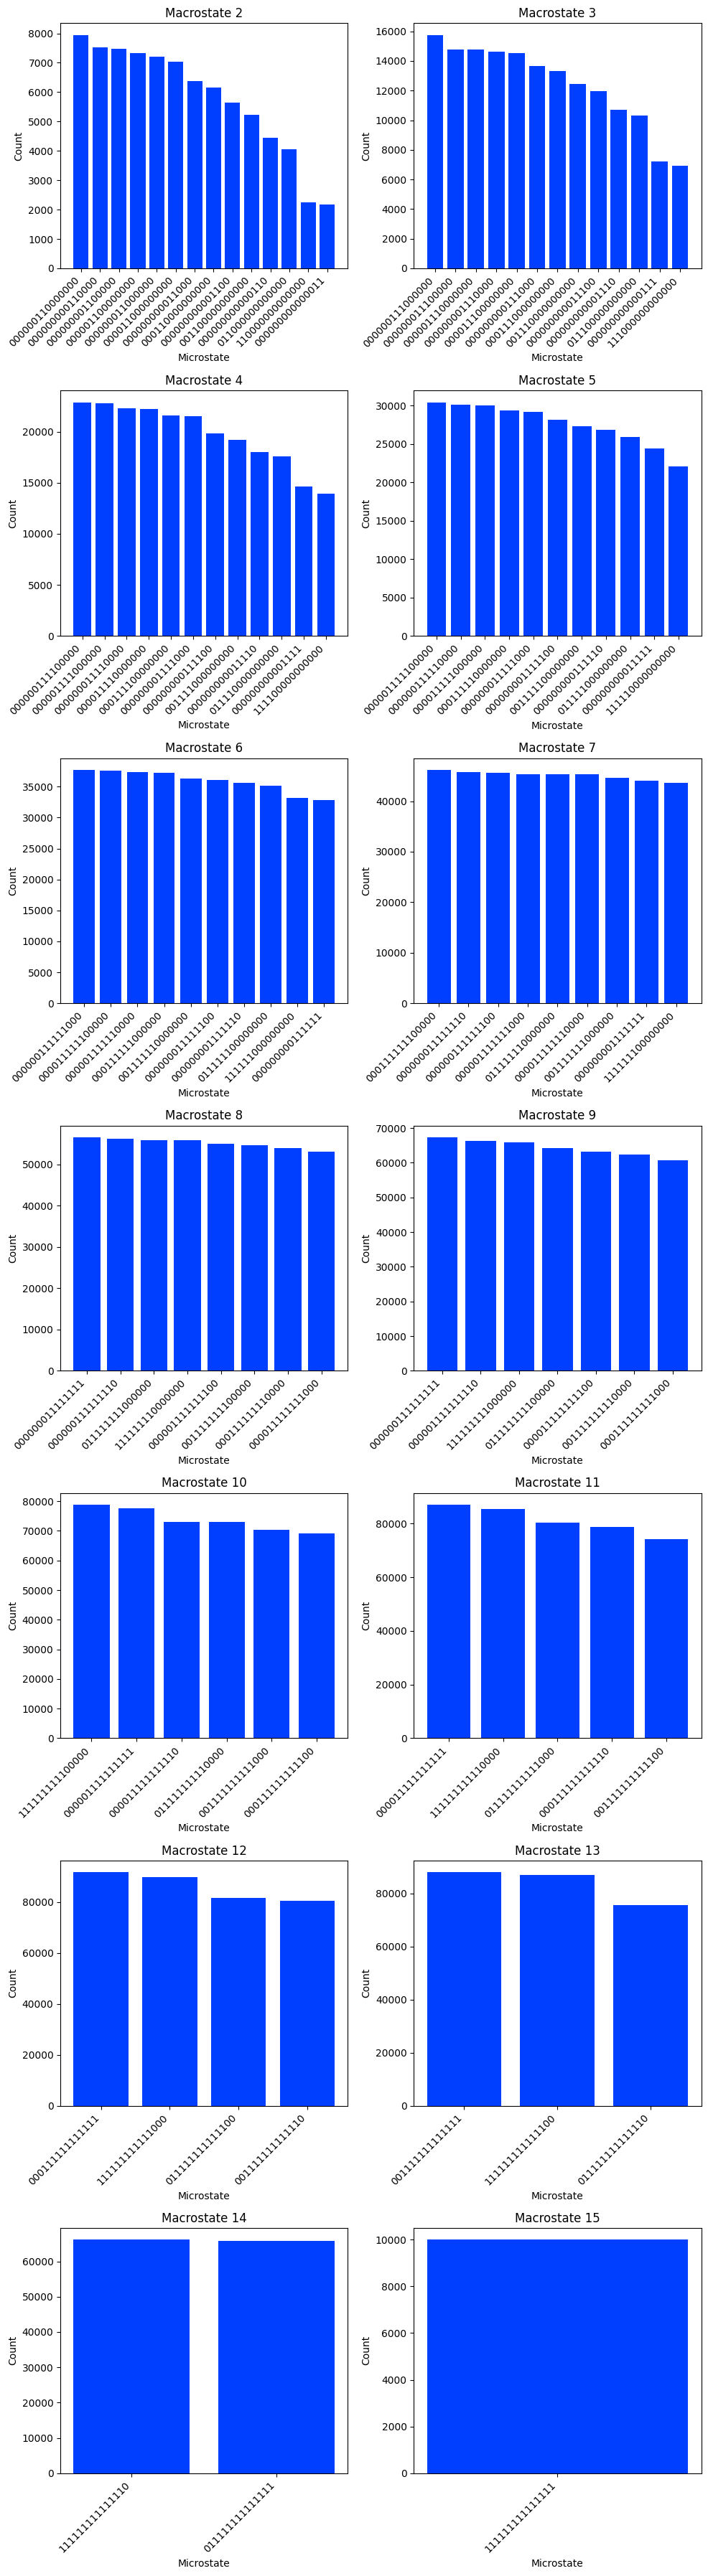

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

microstate, count = zip(*sorted_microstates)
macrostate = []
for i in range(len(microstate)):
    temp_lst = [int(i) for i in microstate[i]]
    nhelix = sum(temp_lst)
    macrostate.append(nhelix)

print(microstate)
print(count)
print(macrostate)

df = pd.DataFrame({'microstate': microstate, 'count': count, 'macrostate': macrostate})
macro_groups = df.groupby('macrostate')

macro_groups = sorted(macro_groups, key=lambda x: x[0])

num_plots = len(macro_groups) - LO_THRESH
fig, ax = plt.subplots(nrows = (num_plots+1) // 2 + (num_plots+1) % 2, ncols= 2, figsize=(10, 3*num_plots))

for i, group in enumerate(macro_groups):
    name, group = group
    row = i // 2
    col = i % 2
    # plot only after macrostate 4
    if name < LO_THRESH:
        continue
    ax[row, col].bar(x=group['microstate'], height=group['count'])
    ax[row, col].set_title(f'Macrostate {name}')
    ax[row, col].set_xlabel('Microstate')
    ax[row, col].set_ylabel('Count')
    ax[row, col].set_xticklabels(group['microstate'], rotation=45, ha='right')

plt.tight_layout()
plt.show()




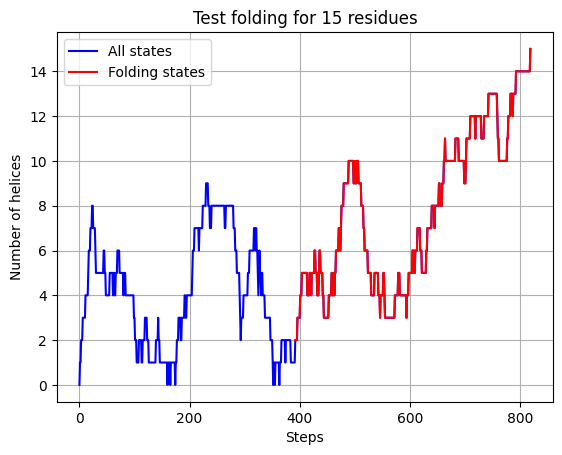

In [11]:
# plotting the folding path
folding_path = get_folding_route(path)
folding_macrostates = []
for state in folding_path:
    temp_lst = [int(i) for i in state]
    nhelix = sum(temp_lst)
    folding_macrostates.append(nhelix)


plt.plot(macrostates, color='blue')
plt.plot(range(len(macrostates)-len(folding_macrostates), len(macrostates)), folding_macrostates, color='red')
plt.legend(['All states', 'Folding states'])
plt.xlabel('Steps')
plt.ylabel('Number of helices')
plt.title('Test folding for 15 residues')
plt.grid()
plt.show()

In [12]:
from collections import Counter
arr=Counter(all_path[0])

In [13]:
all_state=generate_ssa_seqs(15)

In [14]:
all_path[7]

{'000000000000000',
 '000000000000001',
 '000000000000010',
 '000000000000011',
 '000000000000100',
 '000000000000110',
 '000000000000111',
 '000000000001000',
 '000000000001100',
 '000000000010000',
 '000000000011000',
 '000000000011100',
 '000000000100000',
 '000000000110000',
 '000000000111000',
 '000000000111100',
 '000000000111110',
 '000000001000000',
 '000000001100000',
 '000000001110000',
 '000000001111000',
 '000000001111100',
 '000000001111110',
 '000000001111111',
 '000000010000000',
 '000000011100000',
 '000000011110000',
 '000000011111000',
 '000000011111100',
 '000000011111110',
 '000000011111111',
 '000000100000000',
 '000000111100000',
 '000000111110000',
 '000000111111000',
 '000000111111110',
 '000000111111111',
 '000001111110000',
 '000001111111000',
 '000001111111100',
 '000001111111110',
 '000001111111111',
 '000010000000000',
 '000011111111000',
 '000011111111100',
 '000011111111110',
 '000011111111111',
 '000100000000000',
 '000110000000000',
 '000111110000000',


In [15]:
one_h=[]
for i in range(len(all_state)):
    if (sum(int(digit) for digit in all_state[i]) == 1):
        one_h.append(all_state[i])

In [16]:
microstate_counts = {}

for path in all_path:
    for microstate in path:
        microstate_counts[microstate] = (microstate_counts.get(microstate, 0) + 1)

sorted_microstates = sorted(microstate_counts.items(), key=lambda x: x[1], reverse=True)

print(sorted_microstates)

[('000000000000000', 10000), ('111111111111111', 9999), ('011111111111110', 7627), ('011111111111100', 7341), ('001111111111110', 7304), ('001111111111100', 7245), ('011111111111111', 6982), ('000111111111110', 6908), ('001111111111000', 6895), ('000111111111100', 6864), ('011111111111000', 6860), ('111111111111110', 6787), ('000111111111000', 6609), ('001111111110000', 6595), ('001111111111111', 6555), ('000011111111100', 6494), ('000011111111110', 6493), ('011111111110000', 6493), ('111111111111100', 6488), ('000111111110000', 6383), ('000011111111000', 6322), ('001111111100000', 6284), ('000001111111100', 6254), ('000111111111111', 6230), ('000001111111110', 6195), ('011111111100000', 6192), ('000011111110000', 6159), ('000111111100000', 6151), ('111111111111000', 6148), ('000001111111000', 6104), ('001111111000000', 5946), ('011111111000000', 5937), ('000000111111100', 5932), ('000011111100000', 5910), ('000000111111110', 5904), ('000011111111111', 5887), ('111111111110000', 5861),

In [17]:
import pandas as pd
final=pd.DataFrame(sorted_microstates)

In [18]:
nhel=[]
for i in range(len(final)):
    nhel.append(sum(int(digit) for digit in final[0][i]))


In [19]:
final.insert(loc=1,column='1',value=nhel)
df_sorted = final.sort_values(by='1')
df_sorted.to_csv("state_occ.txt",sep=' ',index=False,header=None)

In [20]:
df_sorted[1]

,1
0,10000
97,4859
98,4857
99,4839
96,4869
...,...
2,7627
18,6488
6,6982
11,6787


([<matplotlib.axis.XTick at 0x7ab8b909bd50>,
 [Text(0, 0, '000000000000000'),
  Text(1, 0, '000000001000000'),
  Text(2, 0, '000000000010000'),
  Text(3, 0, '000100000000000'),
  Text(4, 0, '000000010000000'),
  Text(5, 0, '000000000001000'),
  Text(6, 0, '001000000000000'),
  Text(7, 0, '000000000000100'),
  Text(8, 0, '010000000000000'),
  Text(9, 0, '000000000000010'),
  Text(10, 0, '000000000000001'),
  Text(11, 0, '100000000000000'),
  Text(12, 0, '000000100000000'),
  Text(13, 0, '000001000000000'),
  Text(14, 0, '000010000000000'),
  Text(15, 0, '000000000100000'),
  Text(16, 0, '000000110000000'),
  Text(17, 0, '000011000000000'),
  Text(18, 0, '000000001100000'),
  Text(19, 0, '000000000001100'),
  Text(20, 0, '001100000000000'),
  Text(21, 0, '000000000110000'),
  Text(22, 0, '000110000000000'),
  Text(23, 0, '000000000011000'),
  Text(24, 0, '000001100000000'),
  Text(25, 0, '000000000000011'),
  Text(26, 0, '000000000000110'),
  Text(27, 0, '000000011000000'),
  Text(28, 0,

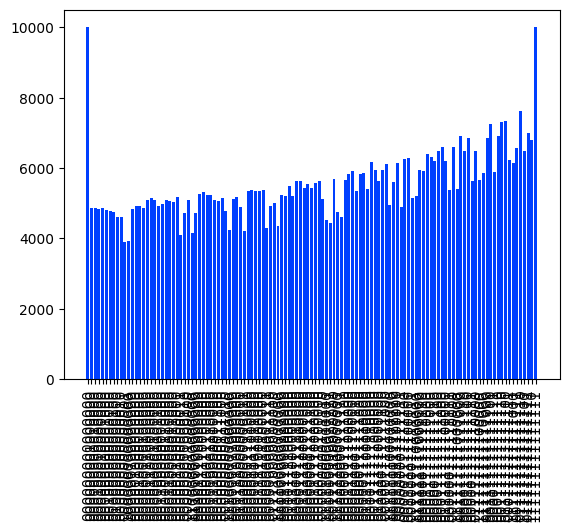

In [21]:
plt.bar(np.arange(0,len(df_sorted)),df_sorted[1])
plt.xticks(np.arange(0,len(df_sorted)),df_sorted[0],rotation = 90)